In [34]:

# %load_ext autoreload

# %autoreload 2

from RNN2DFA.LSTM import LSTMNetwork
# from GRU import GRUNetwork
from RNN2DFA.RNNClassifier import RNNClassifier
from RNN2DFA.Training_Functions import mixed_curriculum_train,make_train_set_for_target
import Tomita_Grammars 
from lstar_extraction.Training_Functions import make_test_set
from RNNexplainer import Explainer
import pandas as pd






The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:



# make training set
target = Tomita_Grammars.tomita_email
alphabet = "ab"


# use a dfa to generate training set
target_formula="G(b->G(~a))"
fout=open("log.txt", "a")
fout.write(".........................................................................\n")
fout.write("Target: "+ target_formula)
fout.write("\n")
fout.close()
import LTL2DFA as ltlf2dfa
generator_dfa=ltlf2dfa.translate_ltl2dfa(alphabet=[character for character in alphabet],formula=target_formula)
print(generator_dfa)


# alphabet = "abcd"
train_set = make_train_set_for_target(generator_dfa.classify_word,alphabet)

# define rnn
rnn = RNNClassifier(alphabet,num_layers=1,hidden_dim=10,RNNClass = LSTMNetwork)


# print(train_set)
# for key in train_set:
#     if(train_set[key]):
#         print(key)
# print(train_set)


DFA:->
 - alphabet: ['a', 'b']
 - Q: [1, 2, 3, 4]
 - q0: 1
 - F: [2, 3]
 - delta: {1: {'00': 2, '01': 3, '10': 2, '11': 4}, 2: {'00': 2, '01': 3, '10': 2, '11': 4}, 3: {'00': 3, '01': 3, '10': 4, '11': 4}, 4: {'00': 4, '01': 4, '10': 4, '11': 4}}
 - is_singleton_graph: False
made train set of size: 429 , of which positive examples: 74
{'': True, 'b': True, 'a': True, 'aa': True, 'ab': True, 'bb': True, 'ba': False, 'aaa': True, 'aab': True, 'bbb': True, 'abb': True, 'bab': False, 'baa': False, 'aba': False, 'bba': False, 'aaab': True, 'abbb': True, 'aabb': True, 'aaaa': True, 'bbbb': True, 'abaa': False, 'aaba': False, 'bbaa': False, 'baaa': False, 'babb': False, 'abba': False, 'baab': False, 'bbba': False, 'baba': False, 'bbab': False, 'abab': False, 'aaabb': True, 'abbbb': True, 'aaaaa': True, 'aabbb': True, 'aaaab': True, 'bbbbb': True, 'aabab': False, 'aabaa': False, 'abaaa': False, 'bbbaa': False, 'babaa': False, 'baabb': False, 'bbaab': False, 'babab': False, 'bbbba': False, 'aba

current average loss is:  0.06776865768914271
current average loss is:  0.012471883606654827
current average loss is:  0.004136176752349869
current average loss is:  0.0020016894410035072
current average loss is:  0.0012116230196423


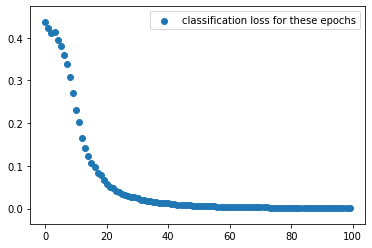

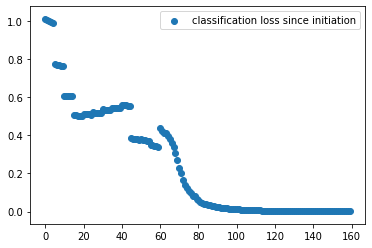

current average loss is:  0.0008535577561749723
current average loss is:  0.0006396931646031377
current average loss is:  0.0005126278369854658


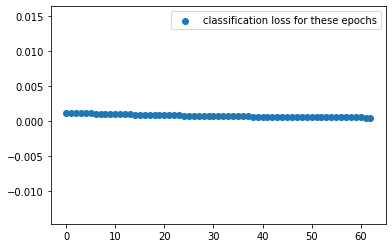

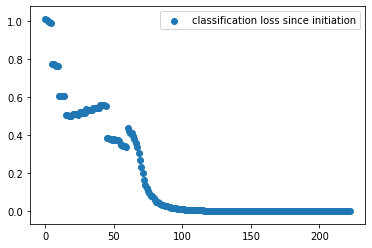

classification loss on last batch was: 0.000498007088552266


In [69]:
# train the model
mixed_curriculum_train(rnn,train_set,stop_threshold = 0.0005)
rnn.renew()  


In [70]:
"""  
from lstar implementation
"""

if(False):

    # starting examples
    # all_words = sorted(list(train_set.keys()),key=lambda x:len(x))
    # pos = next((w for w in all_words if rnn.classify_word(w)==True),None)
    # neg = next((w for w in all_words if rnn.classify_word(w)==False),None)
    # starting_examples = [w for w in [pos,neg] if not None == w]



    # extract DFA from RNN
    from RNN2DFA.Extraction import extract


    dfa_from_rnn = extract(rnn,time_limit = 50,initial_split_depth = 10,starting_examples=None)


    # some statistics
    from math import pow
    def percent(num,digits=2):
        tens = pow(10,digits)
        return str(int(100*num*tens)/tens)+"%"

    dfa_from_rnn.draw_nicely(maximum=30) #max size willing to draw

    test_set = train_set 
    print("testing on train set, i.e. test set is train set")
    # we're printing stats on the train set for now, but you can define other test sets by using
    # make_train_set_for_target again

    n = len(test_set)
    print("test set size:", n)
    pos = len([w for w in test_set if target(w)])
    print("of which positive:",pos,"("+percent(pos/n)+")")
    rnn_target = len([w for w in test_set if rnn.classify_word(w)==target(w)])
    print("rnn score against target on test set:",rnn_target,"("+percent(rnn_target/n)+")")
    dfa_rnn = len([w for w in test_set if rnn.classify_word(w)==dfa_from_rnn.classify_word(w)])
    print("extracted dfa score against rnn on test set:",dfa_rnn,"("+percent(dfa_rnn/n)+")")
    dfa_target = len([w for w in test_set if dfa_from_rnn.classify_word(w)==target(w)])
    print("extracted dfa score against target on rnn's test set:",dfa_target,"("+percent(dfa_target/n)+")")

else:
    """  
    Igor's code:
    The model itself is implemented as a DFA. 
    """


    dfa_from_rnn=rnn 

In [75]:
# use a query LTL formula
import LTL2DFA as ltlf2dfa
query_formula="G(a)"
query_dfa=ltlf2dfa.translate_ltl2dfa(alphabet=[character for character in alphabet],formula=query_formula)
# print(query_dfa)
# query_dfa=No


# make test_set supported by query dfa
sample_test_set=make_train_set_for_target(query_dfa.classify_word, alphabet)

# only consider sample that are true
test_set=[]
for key in sample_test_set:
    if(sample_test_set[key]):
        test_set.append(key)
# print(test_set[:30])

from PACTeacher.pac_teacher import PACTeacher as Teacher 

# query_dfa=None

if(query_dfa is None):
    query_formula=None
    test_set=make_test_set(alphabet)


from RNNexplainer import Traces
traces=Traces(rnn, alphabet)
traces.label_from_network(test_set)
traces.write_in_file()


explainer=Explainer(alphabet=[character for character in alphabet])
teacher = Teacher(dfa_from_rnn,epsilon=.001, delta=.001, max_trace_length=10, max_formula_depth=10, query_dfa=query_dfa)
from time import clock
start_time=clock()
flag=teacher.teach(explainer,traces)
end_time=clock()


print("\n\nepsilon=", teacher.epsilon, "delta=", teacher.delta, "max_trace_length=", teacher.max_trace_length)
print("query:", query_formula)
print("final ltl: ", explainer.ltl)

fout=open("log.txt", "a")
fout.write("\n\nquery: "+query_formula)
fout.write("\nfinal LTL: "+ explainer.ltl)
if(not flag):
    fout.write(" [incomplete]")
    print("incomplete formula")
fout.write("\n\n")

print("\nTime taken:", end_time-start_time)

fout.close()


# statistics

def percent(num,digits=2):
    tens = pow(10,digits)
    return int(100*num*tens)/tens

test_set = train_set 
print("testing on train set, i.e. test set is train set")
# we're printing stats on the train set for now, but you can define other test sets by using
# make_train_set_for_target

n = len(test_set)
print("test set size:", n)
pos = len([w for w in test_set if generator_dfa.classify_word(w)])
print("of which positive:",pos,"("+str(percent(pos/n))+")")
rnn_target = len([w for w in test_set if rnn.classify_word(w)==generator_dfa.classify_word(w)])
print("rnn score against target on test set:                             ",rnn_target,"("+str(percent(rnn_target/n))+")")

fout=open("log.txt", "a")
fout.write("rnn score against target on test set:                             "+str(rnn_target)+"("+str(percent(rnn_target/n))+")")
fout.write("\n")

performance_ltl = len([w for w in test_set if rnn.classify_word(w)==explainer.dfa.classify_word(w)])
print("extracted LTL score against rnn on test set:                      ",performance_ltl,"("+str(percent(performance_ltl/n))+")")
performance_ltl_with_target = len([w for w in test_set if explainer.dfa.classify_word(w)==generator_dfa.classify_word(w)])
print("extracted LTL score against target on rnn's test set:             ",performance_ltl_with_target,"("+str(percent(performance_ltl_with_target/n))+")")

performance_ltl = len([w for w in test_set if (rnn.classify_word(w)and query_dfa.classify_word(w)) ==explainer.dfa.classify_word(w)])
print("extracted LTL score against rnn on test set (with query):         ",performance_ltl,"("+str(percent(performance_ltl/n))+")")
fout.write("extracted LTL score against rnn on test set (with query):         "+str(performance_ltl)+"("+str(percent(performance_ltl/n))+")\n")
performance_ltl_with_target = len([w for w in test_set if explainer.dfa.classify_word(w)== (generator_dfa.classify_word(w) and query_dfa.classify_word(w))])
print("extracted LTL score against target on rnn's test set (with query):",performance_ltl_with_target,"("+str(percent(performance_ltl_with_target/n))+")")

fout.write("extracted LTL score against target on rnn's test set (with query):"+str(performance_ltl_with_target)+"("+str(percent(performance_ltl_with_target/n))+")\n")
fout.close()


# report in a pandas file
result = pd.DataFrame(columns=['target', 
                                'query', 
                                'explanation', 
                                'status', 
                                'rnn score', 
                                'explanation score', 
                                'explanation score on ground truth',
                                'extraction time'
                                ])

result = result.append(
    {
        'target':target_formula,
        'query':query_formula,
        'explanation':explainer.ltl,
        'status':flag,
        'rnn score':percent(rnn_target/n),
        'explanation score':percent(performance_ltl/n),
        'explanation score on ground truth':percent(performance_ltl_with_target/n),
        'extraction time': end_time-start_time
    }, ignore_index=True
)
print(result.to_string(index=False))
result.to_csv('result.csv', header=False, index=False, mode='a')


made train set of size: 323 , of which positive examples: 10


positive traces---> 
['a']


negative traces---> 
[]



learned LTL formula: true
new counterexample:   should be rejected by implementation


positive traces---> 
['a']


negative traces---> 
['']







start formula depth: 1
learned LTL formula: a
new counterexample: aaab  should be rejected by implementation


positive traces---> 
['a']


negative traces---> 
['', 'aaab']







start formula depth: 1
learned LTL formula: (G a)


epsilon= 0.001 delta= 0.001 max_trace_length= 10
query: G(a)
final ltl:  (G a)

Time taken: 3.8091459999999984
testing on train set, i.e. test set is train set
test set size: 429
of which positive: 74 (17.24)
rnn score against target on test set:                              429 (100.0)
extracted LTL score against rnn on test set:                       366 (85.31)
extracted LTL score against target on rnn's test set:              366 (85.31)
extracted LTL score against rnn on test set (with que

In [60]:
# read result
df=pd.read_csv("result.csv",header=None)
df.columns=['target', 
            'query', 
            'explanation', 
            'status', 
            'rnn score', 
            'explanation score', 
            'explanation score on ground truth',
            'extraction time'
            ]
print(df.to_string(index=False))

target     query              explanation  status  rnn score  explanation score  explanation score on ground truth  extraction time
 G(~a)         a                    false    True      100.0              100.0                              100.0         2.316631
 G(~a)        ~a                (G (~ a))    True      100.0              100.0                              100.0         2.632458
 G(~a)     G(~a)                (~ (F a))    True      100.0              100.0                              100.0         3.853466
 G(~a)  X(G(~a))  ((G (~ a)) & (X (~ a)))    True      100.0              100.0                              100.0         4.572391
 G(~a)  F(G(~a))                (~ (F a))    True      100.0              100.0                              100.0         2.593367
 G(~a)      true                (G (~ a))    True      100.0              100.0                              100.0         2.594589
